# Visualize Pixel Art Dataset

This notebook shows ~100 samples from each class in `data/` using `PixelArtDataset`.

In [ ]:
from pathlib import Path
import math
import random
import torch
import matplotlib.pyplot as plt

from dataloader import PixelArtDataset

ROOT = Path.cwd()
DATA_DIR = ROOT / "data" / "pixel_art_dataset"
assert DATA_DIR.exists(), f"Expected data folder at: {DATA_DIR}"

In [1]:
import torch

torch.cuda.is_available()

True

In [10]:
# Load dataset (no augmentation for visualization)
dataset = PixelArtDataset(root_dir=str(DATA_DIR), image_size=16, augment=False)

# Class IDs produced by VectorTokenizer are 1..5 (0 is reserved for Null/unconditional)
CLASS_IDS = [1, 2, 3, 4, 5]
N_PER_CLASS = 100

by_class = {cid: [] for cid in CLASS_IDS}

# Iterate in random order so collected samples are random per class (not dataset order)
indices = list(range(len(dataset)))
random.shuffle(indices)

for i in indices:
    img, label = dataset[i]
    cid = int(label.item())
    if cid in by_class and len(by_class[cid]) < N_PER_CLASS:
        by_class[cid].append(img)
    if all(len(by_class[c]) >= N_PER_CLASS for c in CLASS_IDS):
        break

{cid: len(v) for cid, v in by_class.items()}

Found numpy files. Loading from /Users/jurahostic/Documents/Projects/pixel-art-diffusion/data/pixel_art_dataset/sprites.npy...
Loaded 89400 images from numpy files.


{1: 100, 2: 100, 3: 100, 4: 100, 5: 100}

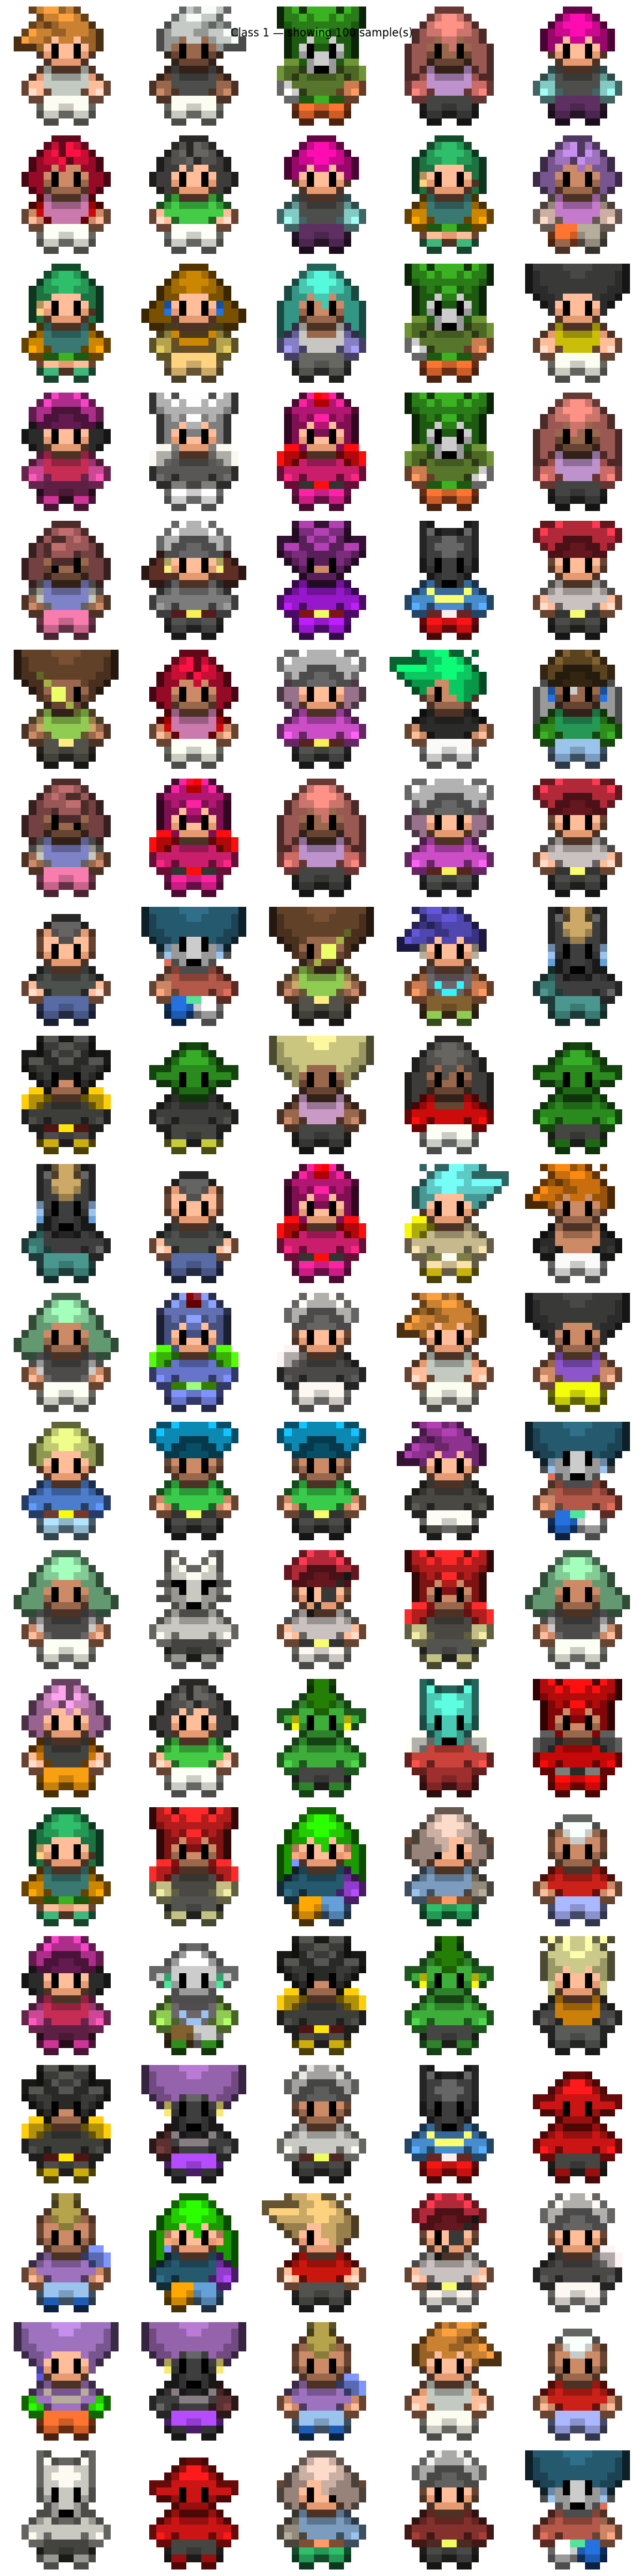

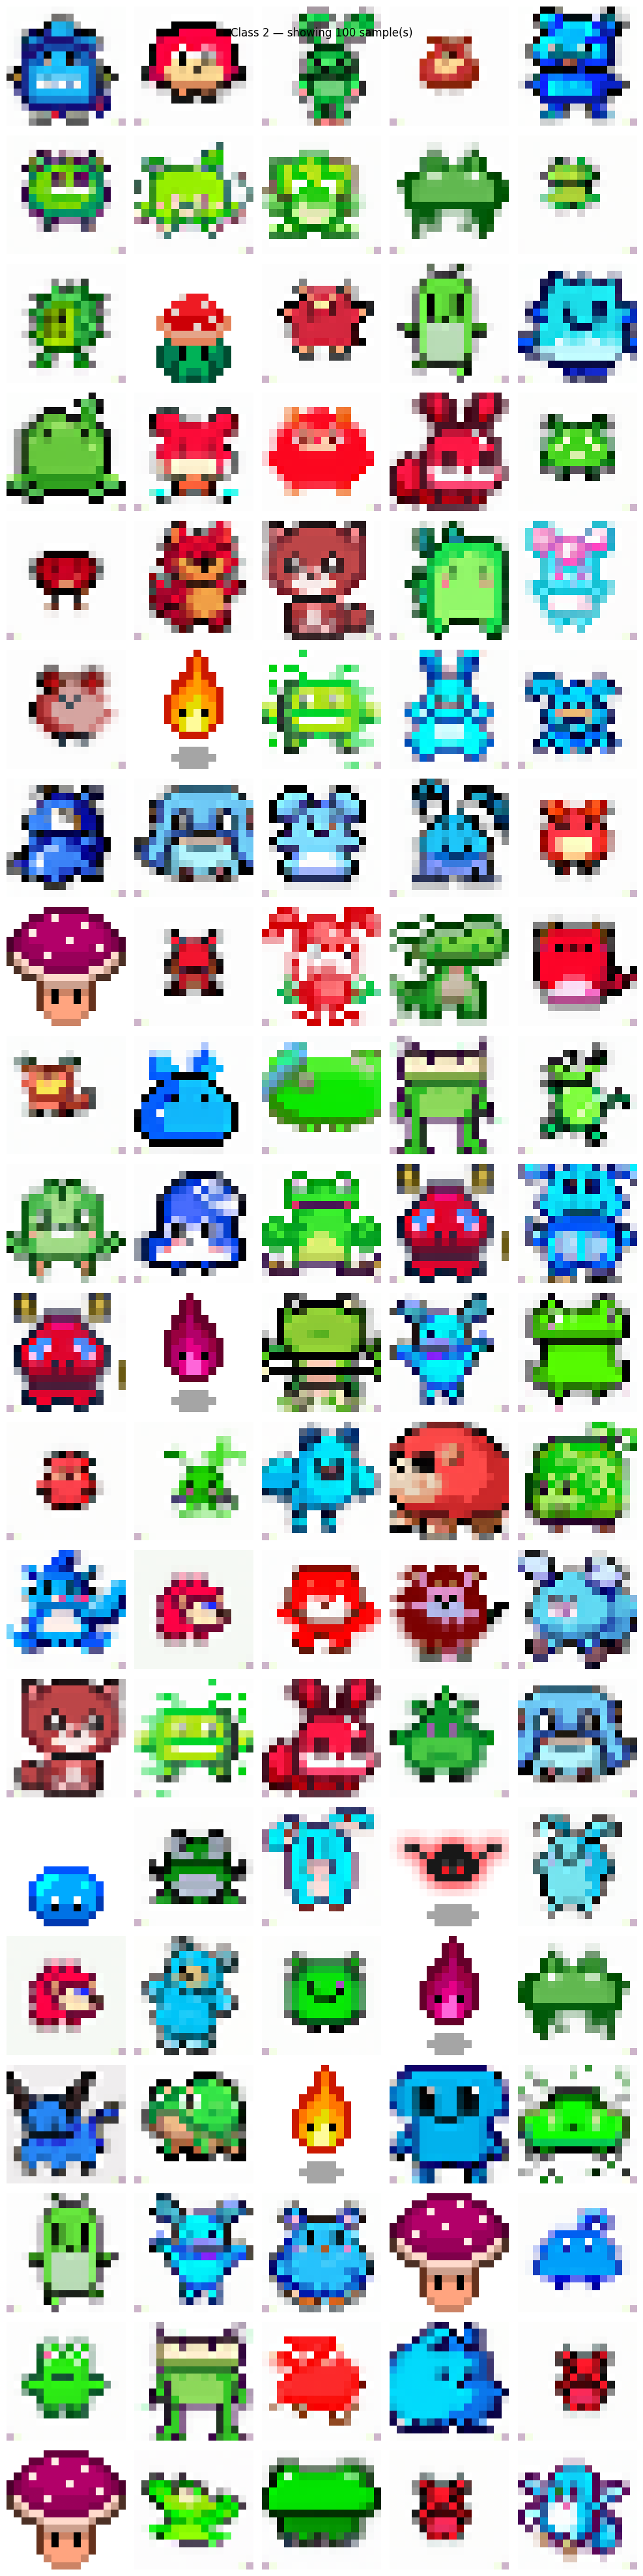

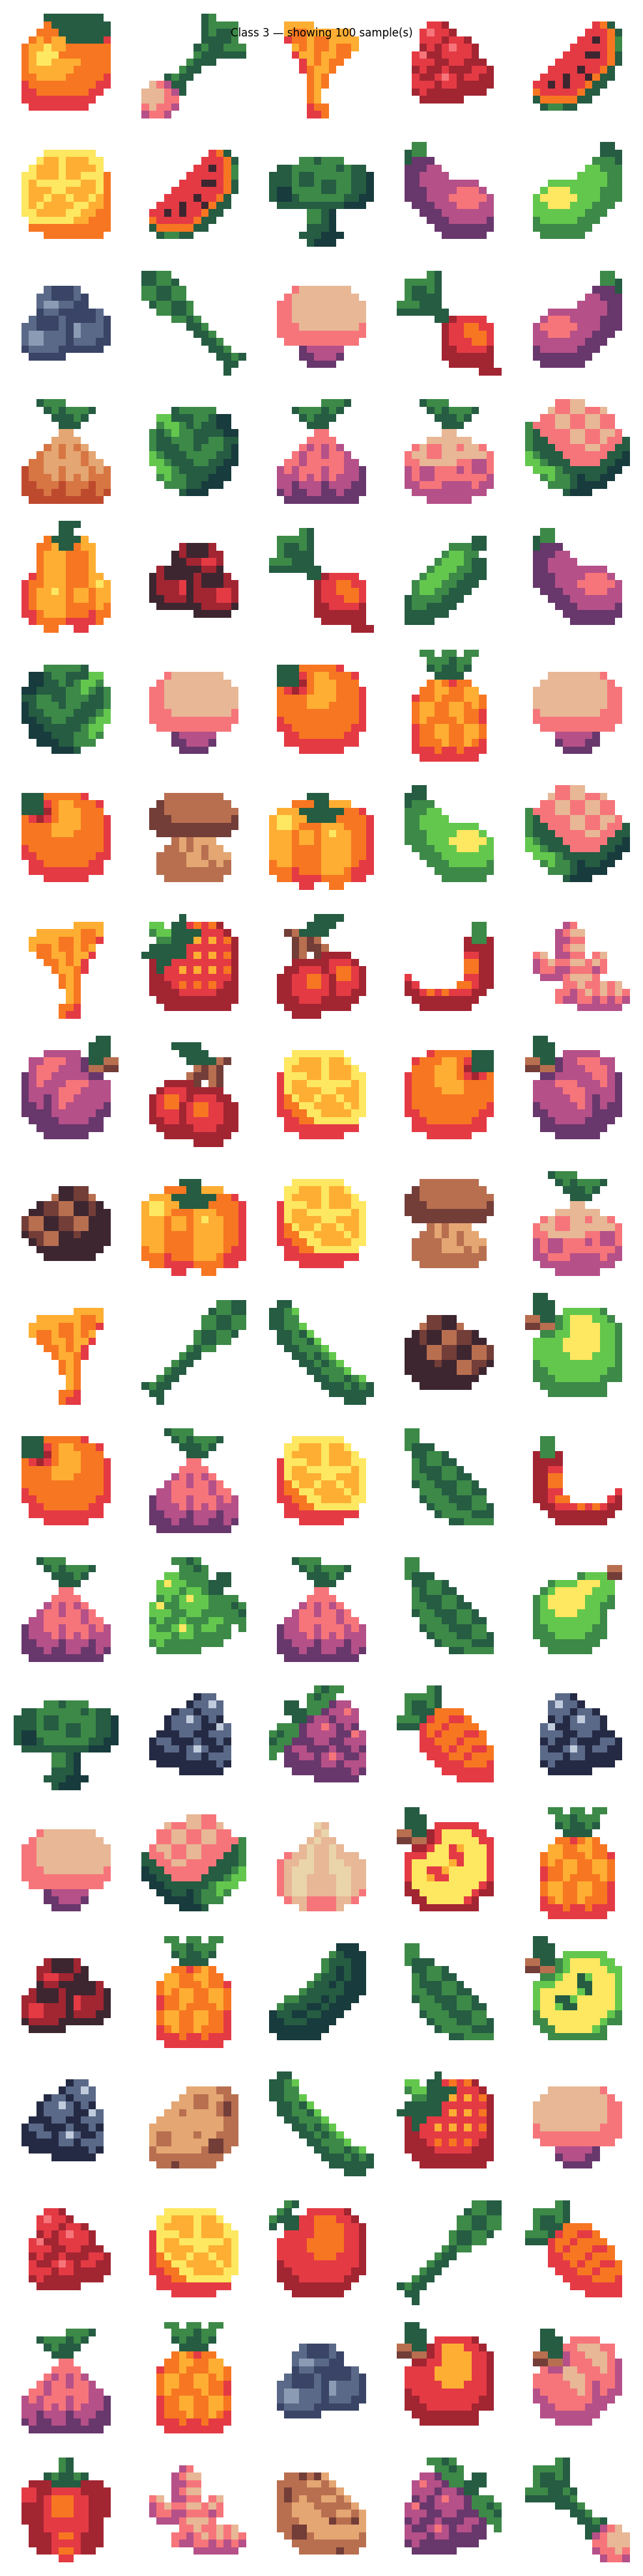

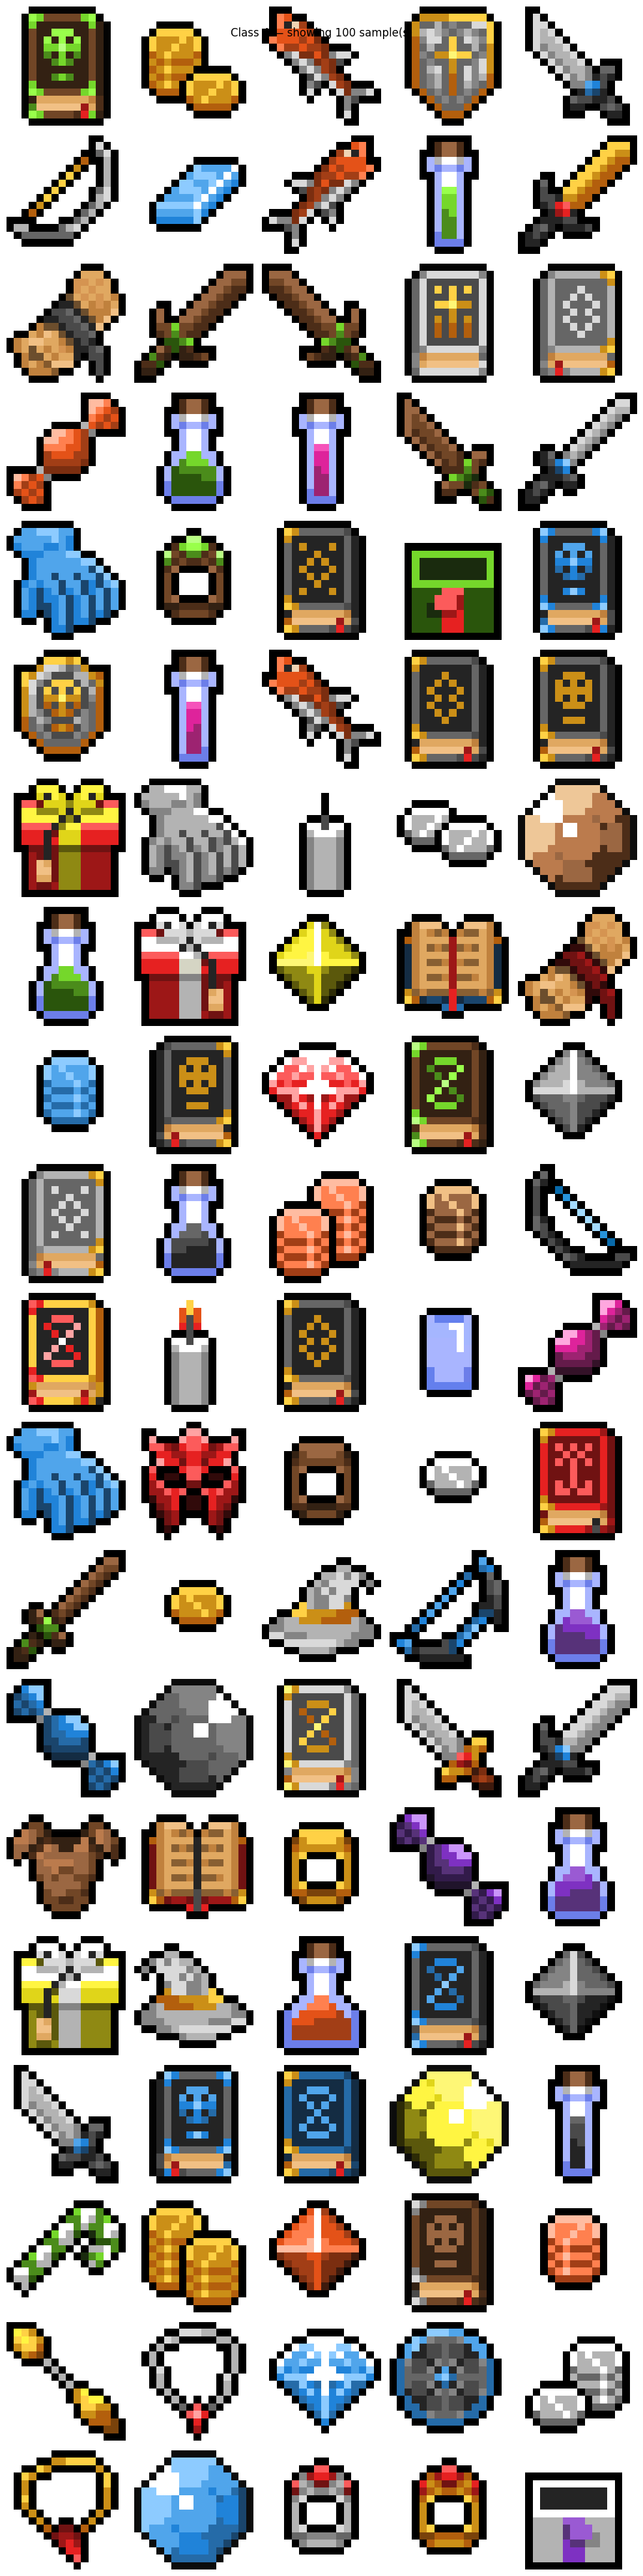

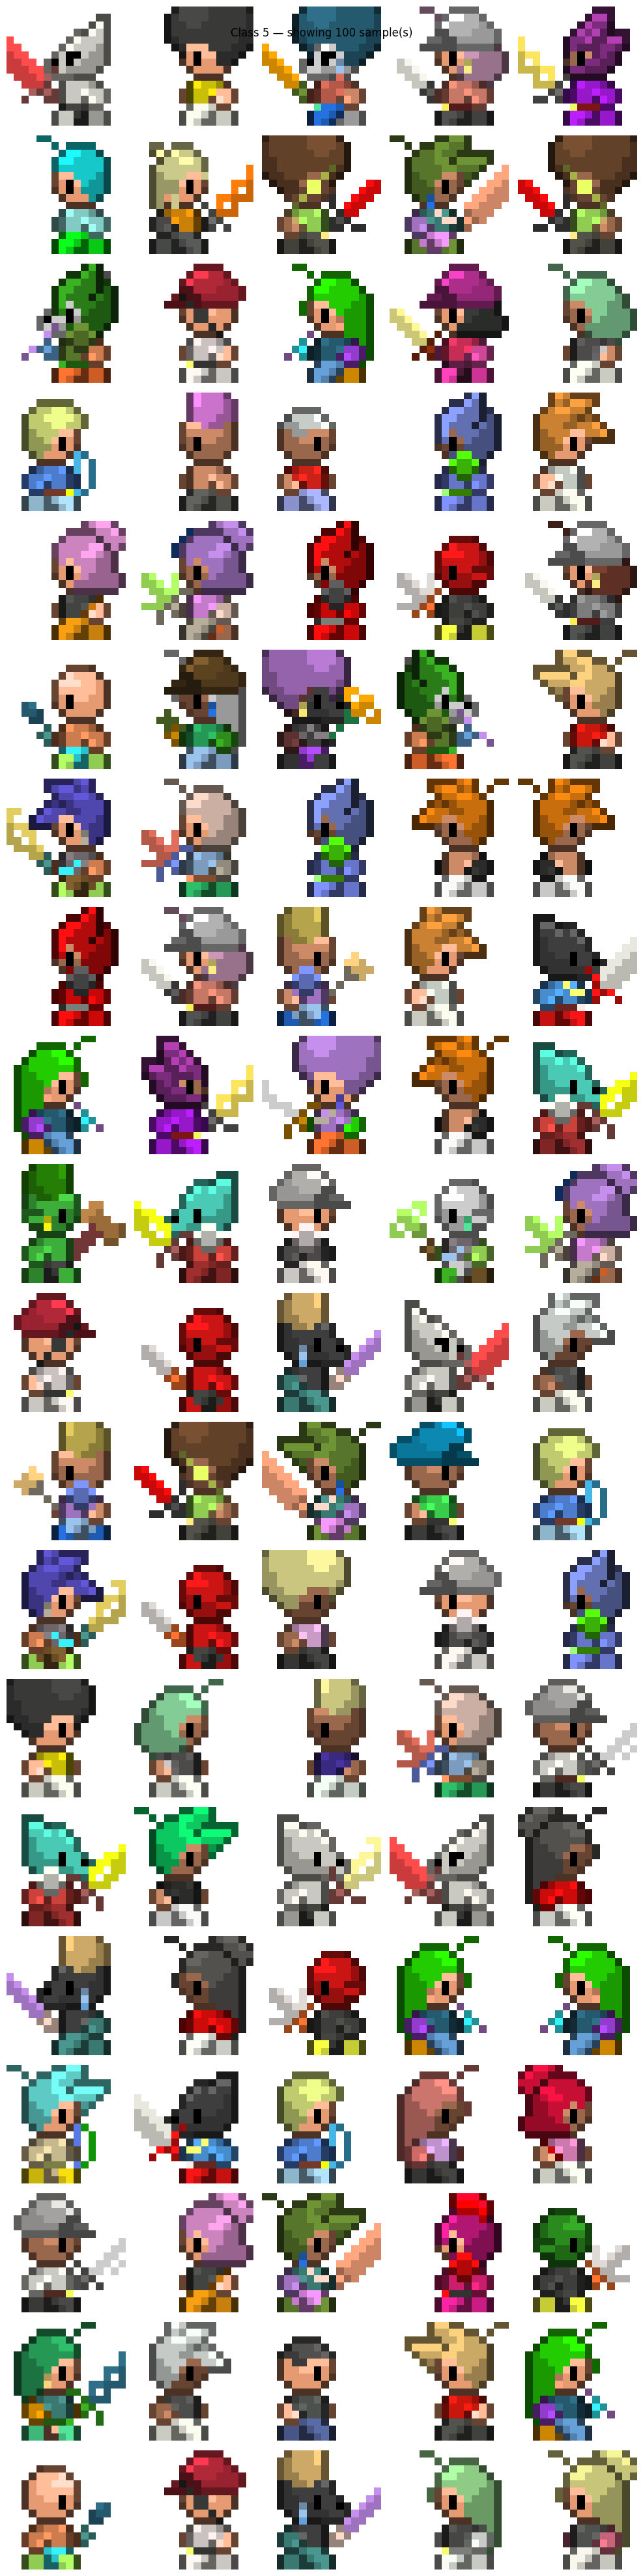

In [11]:
def unnormalize(x: torch.Tensor) -> torch.Tensor:
    # dataset normalization: (x - 0.5) / 0.5  =>  x = x*0.5 + 0.5
    return (x * 0.5 + 0.5).clamp(0, 1)

def show_class_grid(class_id: int, images, ncols: int = 5):
    n = len(images)
    if n == 0:
        print(f"Class {class_id}: no samples found")
        return
    ncols = min(ncols, n)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    axes = axes if isinstance(axes, (list, tuple)) else (axes if hasattr(axes, '__len__') else [axes])
    # Normalize axes into a flat list
    if hasattr(axes, 'ravel'):
        axes = axes.ravel().tolist()
    elif isinstance(axes, list) and len(axes) > 0 and hasattr(axes[0], 'ravel'):
        axes = [ax for row in axes for ax in row]

    for ax in axes:
        ax.axis('off')

    for j, img in enumerate(images):
        img = unnormalize(img).permute(1, 2, 0).cpu().numpy()
        axes[j].imshow(img, interpolation='nearest')

    fig.suptitle(f"Class {class_id} — showing {n} sample(s)")
    plt.tight_layout()
    plt.show()

for cid in CLASS_IDS:
    show_class_grid(cid, by_class[cid], ncols=5)

In [ ]:
# 6. Model Inference and Visualization
from model import ScalableUNet, PixelDiffusion
import os
from pathlib import Path
import torchvision
import matplotlib.pyplot as plt

ROOT = Path.cwd()
DATA_DIR = ROOT / "data" / "pixel_art_dataset"
CLASS_IDS = [1, 2, 3, 4, 5]


device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

# Instantiate model (we assume 5 classes: 1..5, 0 is reserved for Null)
model = ScalableUNet(num_classes=6, img_size=16, base_c=96, t_dim=256).to(device)

# Try to load the latest checkpoint if available
ckpt_dir = ROOT / "checkpoints"
ckpt_files = sorted(ckpt_dir.glob("ckpt_epoch_*.pt"), key=os.path.getmtime) if ckpt_dir.exists() else []
if ckpt_files:
    ckpt_path = ckpt_files[-1]
    print(f"Loading checkpoint {ckpt_path}")
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
else:
    print("No checkpoint found in ./checkpoints. Using randomly initialized model.")

diffusion = PixelDiffusion(model, image_size=16, device=device)

NUM_SAMPLES_PER_CLASS = 8
for cid in CLASS_IDS:
    labels = torch.tensor([cid] * NUM_SAMPLES_PER_CLASS).long().to(device)
    with torch.no_grad():
        samples = diffusion.sample(labels=labels, cfg_scale=3.0)
    # Move to CPU for plotting
    samples = samples.cpu()
    grid = torchvision.utils.make_grid(samples, nrow=4, normalize=False)
    plt.figure(figsize=(6, 6))
    plt.imshow(grid.permute(1, 2, 0).numpy())
    plt.axis('off')
    plt.title(f"Class {cid} samples")
    plt.show()


Using device: cuda


TypeError: ScalableUNet.__init__() got an unexpected keyword argument 't_dim'